In [2]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sb

In [3]:

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot

# fetching the dataset

In [4]:
#fetching the dataset

news_train = fetch_20newsgroups(subset = "train", random_state = 1) #contains the training set
news_test = fetch_20newsgroups(subset = "test") #contains the testing set
#all_news = fetch_20newsgroups(subset = "all") #contains all the news files

In [5]:
#for all files
#all_documents = news_train.data
#all_targets = all_news.target

#for testing files
test_documents = news_test.data
test_targets = news_test.target

#for training files
train_documents = news_train.data
train_targets = news_train.target

print('#train documents',len(train_documents))
print('#train targets',len(train_targets))
print('#test documents',len(test_documents))
print('#test targets',len(test_targets))

#train documents 11314
#train targets 11314
#test documents 7532
#test targets 7532


# creating dataframes for the raw (unclean) data

In [6]:
#all_target_df = pd.DataFrame({"target":all_targets})
train_target_df = pd.DataFrame({"target":train_targets})
test_target_df = pd.DataFrame({"target":test_targets})

#prints all the news categories
print(news_train.target_names)

#display the first five news files in the dataset
train_target_df.head()

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


,target
0,17
1,0
2,17
3,11
4,10


In [7]:
#number of files in the training set categories

pd.DataFrame(news_train.target).value_counts()

10    600
15    599
8     598
9     597
11    595
7     594
13    594
5     593
14    593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
dtype: int64

In [8]:
train_target_df.tail()

,target
11309,17
11310,13
11311,9
11312,4
11313,9


In [9]:
#display all news files in the train set
train_target_df

,target
0,17
1,0
2,17
3,11
4,10
...,...
11309,17
11310,13
11311,9
11312,4


# cleaning train and test sets

Three steps are involved here
1. Removal of all special characters from the news files
2. Removal of all words with less than 3 characters
3. Changing all the text to lower case

In [10]:
##train data cleaning
train_news_df = pd.DataFrame({'document':train_documents})

#removing all special characters and remaining with alphabets only
train_news_df['clean_doc'] = train_news_df['document'].str.replace("[^a-zA-Z]"," ")

#removing all words with less or equal to three characters
train_news_df['clean_doc'] = train_news_df['clean_doc'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

#turning all the words to lower case
train_news_df['clean_doc'] = train_news_df['clean_doc'].apply(lambda x: x.lower())

##test data cleaning
test_news_df = pd.DataFrame({'document':test_documents})

#removing all special characters and remaining with alphabets only
test_news_df['clean_doc'] = test_news_df['document'].str.replace("[^a-zA-Z]"," ")

#removing all words with less or equal to three characters
test_news_df['clean_doc'] = test_news_df['clean_doc'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))

#turning all the words to lower case
test_news_df['clean_doc'] = test_news_df['clean_doc'].apply(lambda x: x.lower())

C:\Program Files\KMSpico\temp\ipykernel_10280\1834725129.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train_news_df['clean_doc'] = train_news_df['document'].str.replace("[^a-zA-Z]"," ")
C:\Program Files\KMSpico\temp\ipykernel_10280\1834725129.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  test_news_df['clean_doc'] = test_news_df['document'].str.replace("[^a-zA-Z]"," ")


In [11]:
#display the first five files with clean data
train_news_df.head()

,document,clean_doc
0,"From: ab4z@Virginia.EDU (""Andi Beyer"")\nSubjec...",from virginia andi beyer subject israeli terro...
1,From: timmbake@mcl.ucsb.edu (Bake Timmons)\nSu...,from timmbake ucsb bake timmons subject amusin...
2,From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...,from cleveland freenet mark kaufman subject re...
3,From: ray@ole.cdac.com (Ray Berry)\nSubject: C...,from cdac berry subject clipper business usual...
4,From: kkeller@mail.sas.upenn.edu (Keith Keller...,from kkeller mail upenn keith keller subject p...


# tokenizing text in the train and test sets

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Karim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
#tokenization

stop_words= stopwords.words('english')
#training set
tokenized_doc_train = train_news_df['clean_doc'].apply(lambda x:x.split())
tokenized_doc_train = tokenized_doc_train.apply(lambda x: [item for item in x if item not in stop_words])

#test set
tokenized_doc_test = test_news_df['clean_doc'].apply(lambda x:x.split())
tokenized_doc_test = tokenized_doc_test.apply(lambda x: [item for item in x if item not in stop_words])

# detokenizing the train and test sets

In [14]:
##deokenize
#train set
detokenized_doc_train =[]
for i in range(len(train_news_df)):
    t = ''.join(tokenized_doc_train[i])
    detokenized_doc_train.append(t)
train_news_df['clean_doc'] = detokenized_doc_train

#test set
detokenized_doc_test =[]
for i in range(len(test_news_df)):
    t = ''.join(tokenized_doc_test[i])
    detokenized_doc_test.append(t)
test_news_df['clean_doc'] = detokenized_doc_test

# creating the first model (svd)

## vectorizing data

In [15]:
vectorizer = TfidfVectorizer(stop_words = 'english',max_features = 1000,max_df =0.5, smooth_idf =True)
X_train=vectorizer.fit_transform(train_news_df['clean_doc'])
X_test=vectorizer.fit_transform(test_news_df['clean_doc'])
print('TF-IDF size: ', X_train.shape)
print('TF-IDF size: ', X_test.shape)

TF-IDF size:  (11314, 1000)
TF-IDF size:  (7532, 1000)


## fitting in the svd(singular value decomposition) model
    This will make our data easy to fit in the logistic regression model
    It divides our data into smaller metrics easy to deal with

In [16]:
svd_model = TruncatedSVD(n_components=20, algorithm='randomized',n_iter=100) #set the # components
svd_model.fit(X_train)
svd_model.fit(X_test)

transformed_train = svd_model.transform(X_train)
transformed_test = svd_model.transform(X_test)

## creating a dataframe for the transformed model

In [17]:
Xdata_train = pd.DataFrame(transformed_train)
Xdata_test = pd.DataFrame(transformed_test)

#dataframe for the training set
Xdata_train


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#dataframe for the testing set
Xdata_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.943597e-49,6.871759e-17,1.907426e-17,4.965655e-17,-1.134179e-16,0.020374,0.000016,-0.002954,-0.002181,-0.013192,-0.009336,0.004526,-0.003678,0.002217,0.007625,-0.007342,0.003290,-0.007862,-0.010571,0.005806
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7527,1.441249e-48,2.829655e-17,3.978156e-19,-4.758845e-19,5.314727e-18,0.015209,-0.004223,0.026945,-0.056351,-0.016975,0.044356,0.000712,0.025674,0.009342,-0.037398,-0.009641,0.027635,0.012248,0.051118,0.034125
7528,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7529,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7530,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# summarizing all the individual news files in the dataset using svd model

1. This is possible through fetching the most important features from the files
2. The accuracy of each summary is returned as well


In [19]:
terms = vectorizer.get_feature_names()

def get_topics(components, feature_names,n=5):
    for idx, topic in enumerate(components):
        print("Topic %d:"%(idx+1), [(feature_names[i], topic[i].round(5)) for i in topic.argsort()[:-n-1:-1]])
get_topics(svd_model.components_,terms)

Topic 1: [('tkelsoafitkelsosubjectlineorbitalelementspaceshuttlekeywordsspaceshuttleorbitalelementskepleriannntppostinghostscgraphafitorganizationforceinstitutetechnologylinescurrentorbitalelementsnoradlineelementsetscarriedcelestialupdateddailypossibledocumentationtrackingsoftwarealsoavailablesystemservicesatelliteusercommunitycurrentelementscurrentshuttlemissionprovidedcelestialaccessedhoursusingdatabitsstopparityelementsetsalsoupdateddailyshuttleelementsdocumentationsoftwarealsoavailableanonymousarchiveafitdirectoryspacekelsoassistantprofessorspaceoperationstkelsoafitforceinstitutetechnology', 1.0), ('uphyaodiebielefeldlarskoellersubjectconfigurationreplyuphyaodiebielefeldnntppostinghostodiebielefeldorganizationchaosunlimitedlineshellowantconfiguresytemrunninglikeunixcommingchoosermenudifferentmachinesworksconnectconnectionworkslocalhostindirectmachineworkswellconfigurationstartingboottimeserversspecifiedxserversstartingserverboottimeindirectlocalhostchoosermenuappearsmachinesnamedx

C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Getting the target values for the transformed data

In [20]:
#classification
clf = LogisticRegression(fit_intercept=False)
clf.fit(Xdata_train,train_target_df) #xdata_train/transformed and train_target_df/value
#clf.fit(Xdata_test,test_target_df) #xdata_test/transformed and test_target_df/value
clf.coef_

C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[-8.76977934e-02, -1.13650923e-01, -3.20651194e-02,
         2.50071382e-02, -8.97235522e-02, -2.77688554e-01,
        -2.98200088e-02, -1.45618371e-01, -2.14085344e-01,
         1.14654817e-01, -3.07935383e-01, -1.02501924e-02,
         1.14577283e-02, -1.47548591e-01,  1.85042745e-01,
         4.64423527e-02, -9.49912427e-02,  3.34863679e-02,
        -4.29177490e-01, -1.60789510e-01],
       [ 7.89280141e-01, -1.13650923e-01, -3.20651194e-02,
         2.50071382e-02, -8.97235522e-02, -2.57474741e-01,
        -1.61273072e-01, -1.69426549e-01, -8.95116505e-02,
         3.50388627e-01, -4.32725484e-01, -2.87960908e-01,
        -1.07961763e-01, -4.67498555e-02,  1.85082227e-01,
         2.48973397e-01,  1.07471556e-01, -2.86189559e-01,
         2.75912372e-01,  1.98570993e-01],
       [ 7.89280141e-01, -1.13650923e-01, -3.20651194e-02,
         2.50071382e-02, -8.97235522e-02, -3.17993923e-02,
        -2.42457626e-02,  1.00443390e-01,  1.45099858e-01,
        -1.23274215e-01,  9.5

In [21]:
#logistic regression model one accuracy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf, Xdata_train, train_target_df, scoring = "accuracy", cv = cv, n_jobs=1, error_score="raise")
print("Accuracy: %.3f (%.ef)" % (mean(n_scores), std(n_scores)))

C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Accuracy: 0.045 (3e-03f)


C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
print(clf.score(Xdata_train, train_target_df))

0.05179423722821283


# creating the second model (logistic regression)

In [23]:
model2 = LogisticRegression(solver='liblinear')
model2.fit(Xdata_train, train_target_df)
prediction = model2.predict(Xdata_train)
print('TF-IDF Logistic Regression {0:.3f}'.format(accuracy_score(train_target_df ,prediction)))

TF-IDF Logistic Regression 0.060


C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
banana = LogisticRegression()
banana.fit(Xdata_train, train_target_df)
score = banana.score(Xdata_train, train_target_df)
print(score)

C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.06027929998232279


In [25]:
pred = clf.predict(Xdata_train)
pred_prob = clf.predict_proba(Xdata_train)

## Receiver Operating Characteristic curves (ROC curves) for the first three news classes(categories)

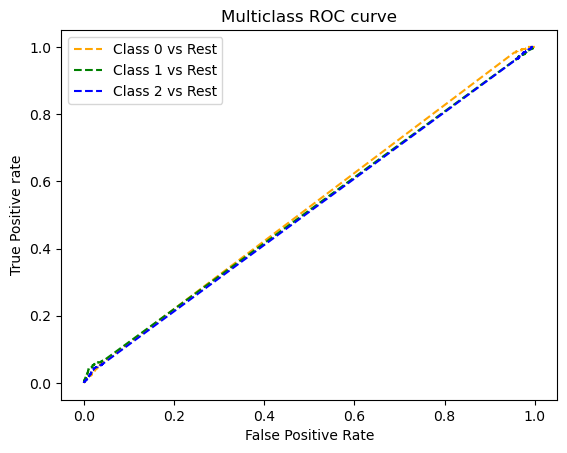

In [26]:
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(train_target_df, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## ROC curves for all the news classes (categories)

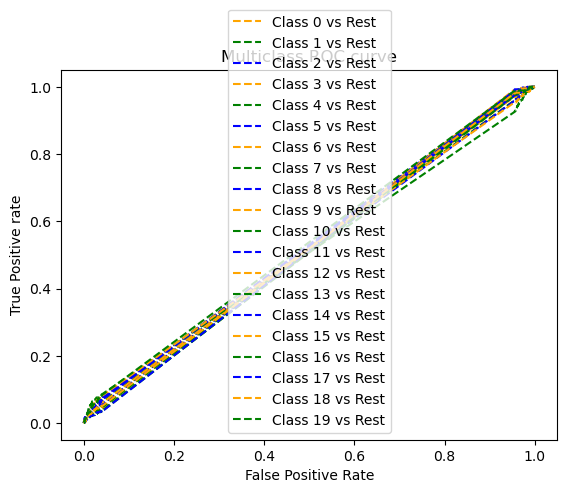

In [27]:
fpr = {}
tpr = {}
thresh ={}

n_class = 20

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(train_target_df, pred_prob[:,i], pos_label=i)
    
# plotting 

plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='orange', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='green', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='blue', label='Class 5 vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='orange', label='Class 6 vs Rest')
plt.plot(fpr[7], tpr[7], linestyle='--',color='green', label='Class 7 vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='blue', label='Class 8 vs Rest')
plt.plot(fpr[9], tpr[9], linestyle='--',color='orange', label='Class 9 vs Rest')
plt.plot(fpr[10], tpr[10], linestyle='--',color='green', label='Class 10 vs Rest')
plt.plot(fpr[11], tpr[11], linestyle='--',color='blue', label='Class 11 vs Rest')
plt.plot(fpr[12], tpr[12], linestyle='--',color='orange', label='Class 12 vs Rest')
plt.plot(fpr[13], tpr[13], linestyle='--',color='green', label='Class 13 vs Rest')
plt.plot(fpr[14], tpr[14], linestyle='--',color='blue', label='Class 14 vs Rest')
plt.plot(fpr[15], tpr[15], linestyle='--',color='orange', label='Class 15 vs Rest')
plt.plot(fpr[16], tpr[16], linestyle='--',color='green', label='Class 16 vs Rest')
plt.plot(fpr[17], tpr[17], linestyle='--',color='blue', label='Class 17 vs Rest')
plt.plot(fpr[18], tpr[18], linestyle='--',color='orange', label='Class 18 vs Rest')
plt.plot(fpr[19], tpr[19], linestyle='--',color='green', label='Class 19 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## ROC curves for individual classes

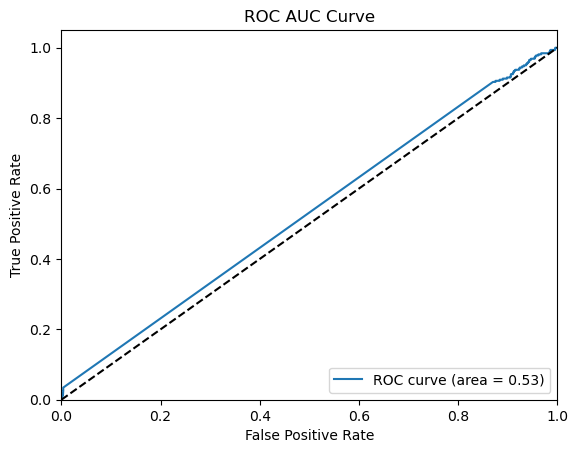

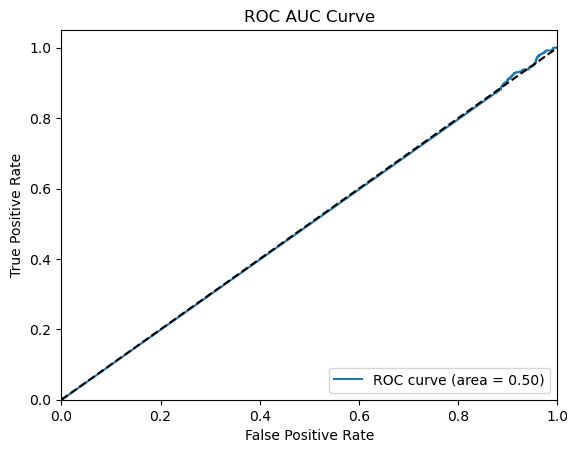

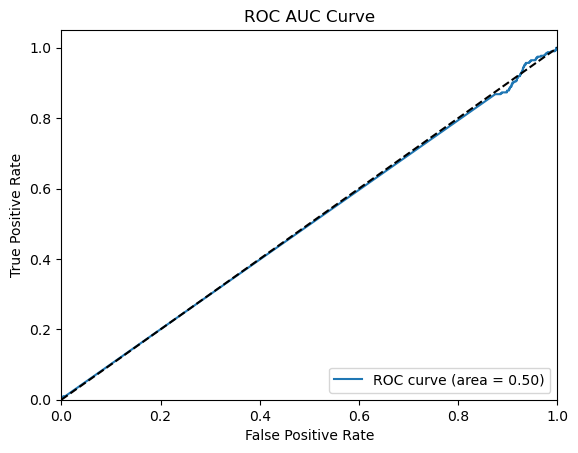

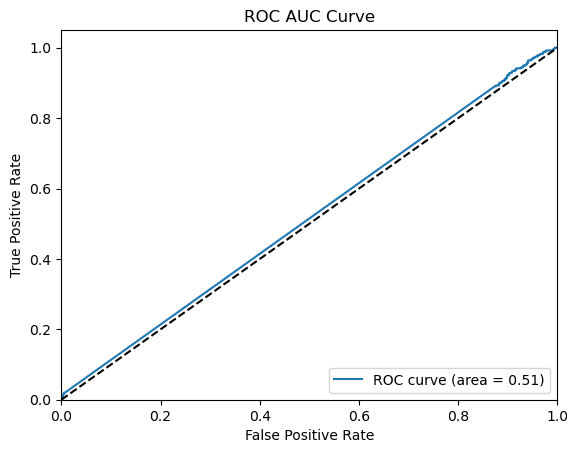

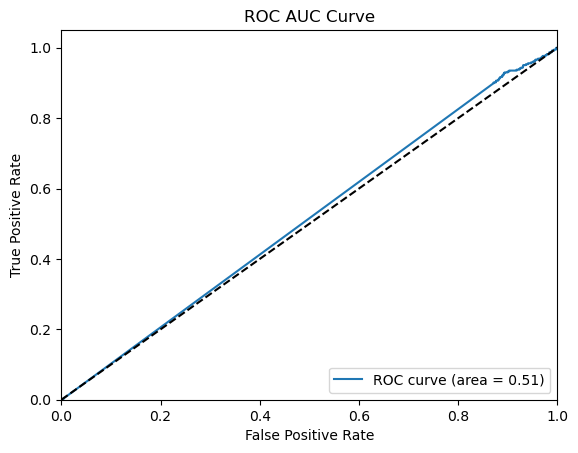

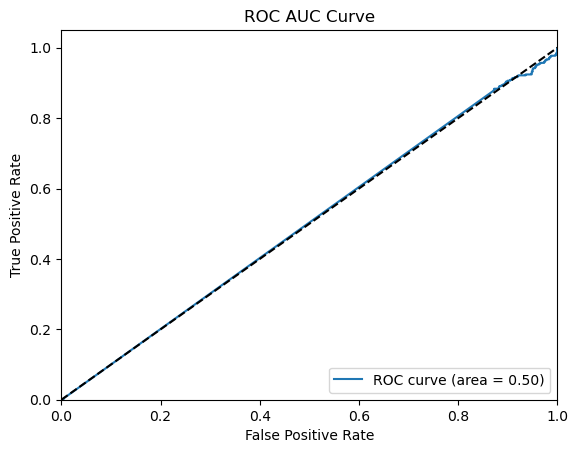

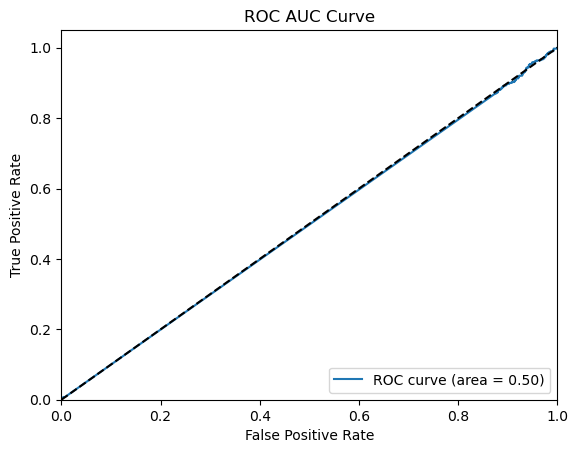

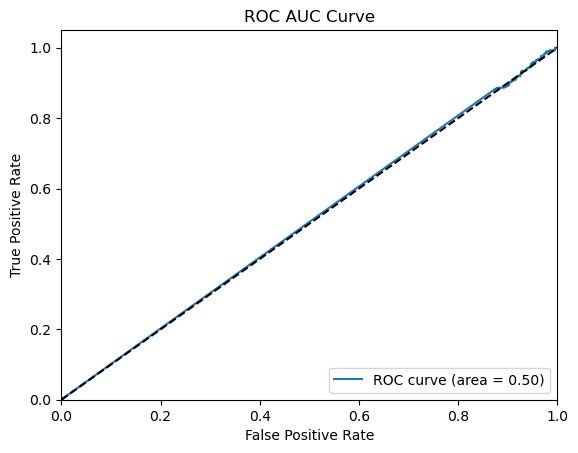

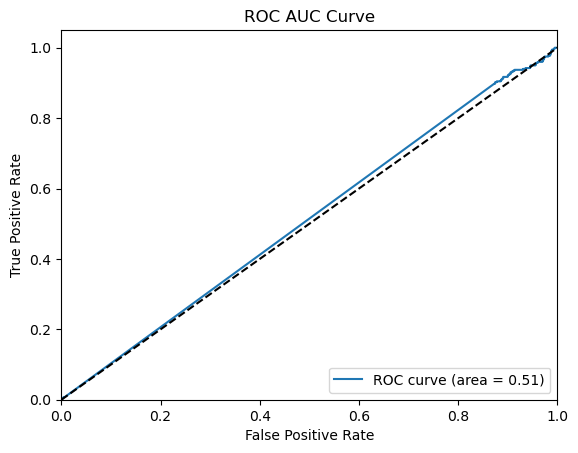

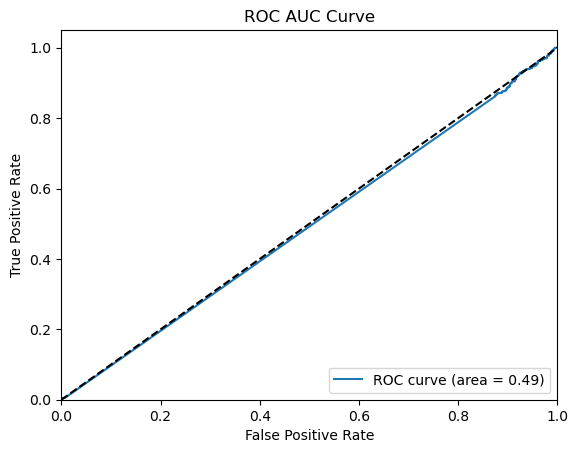

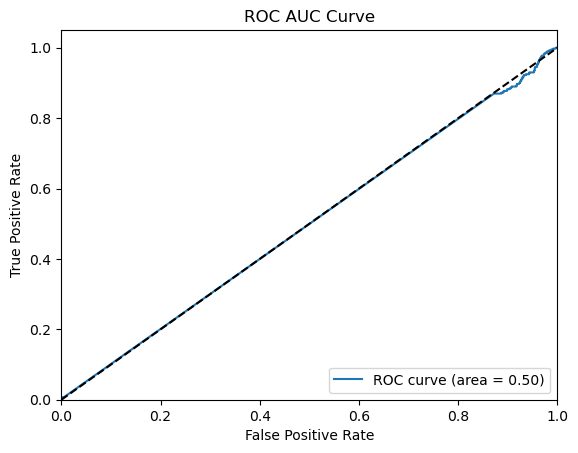

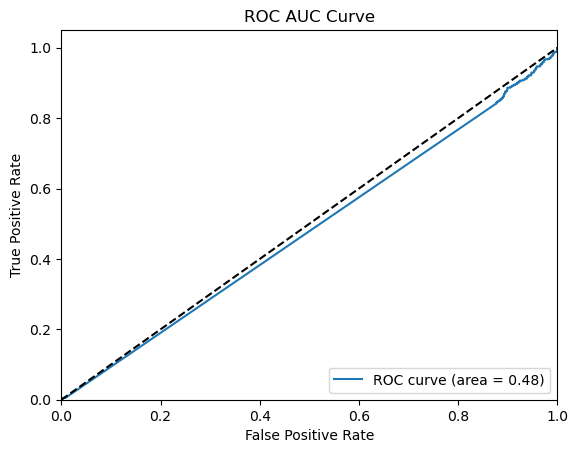

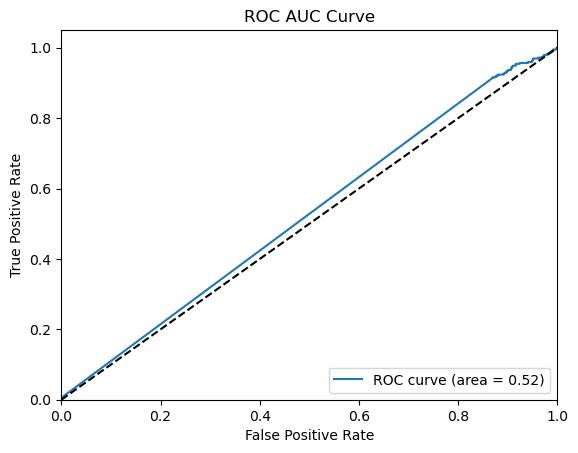

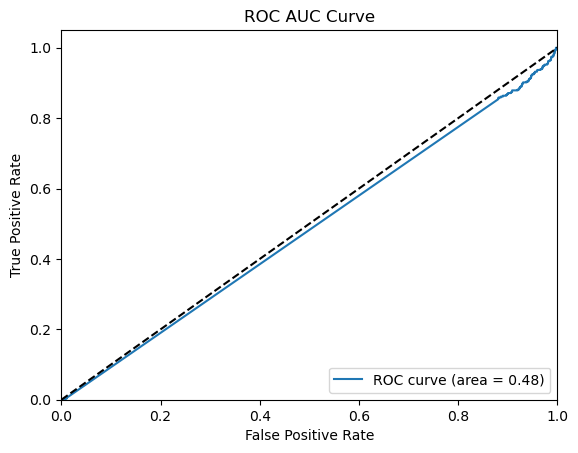

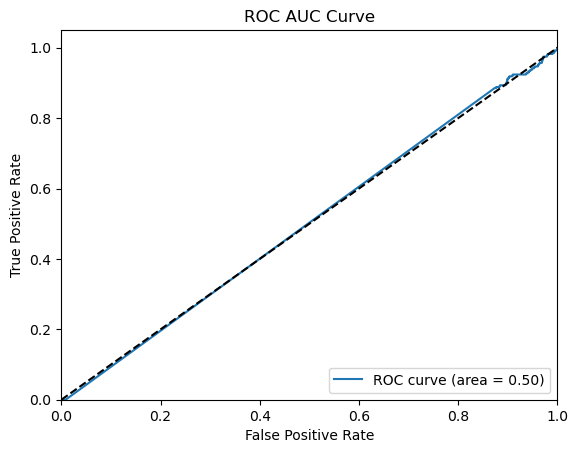

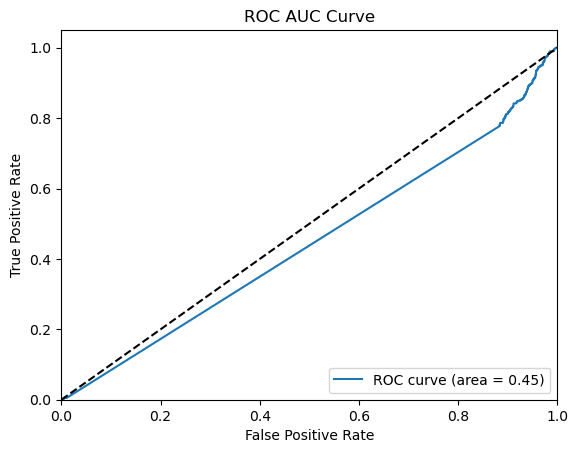

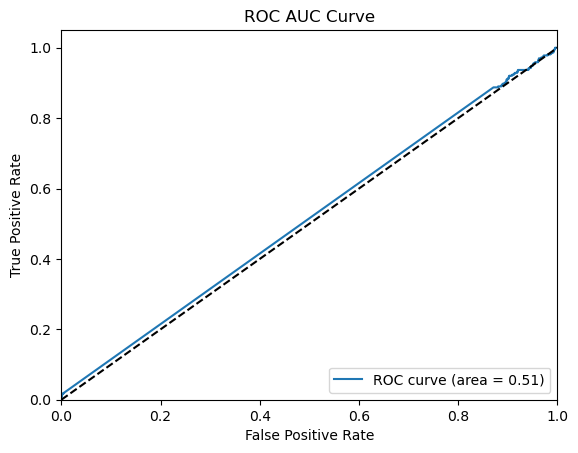

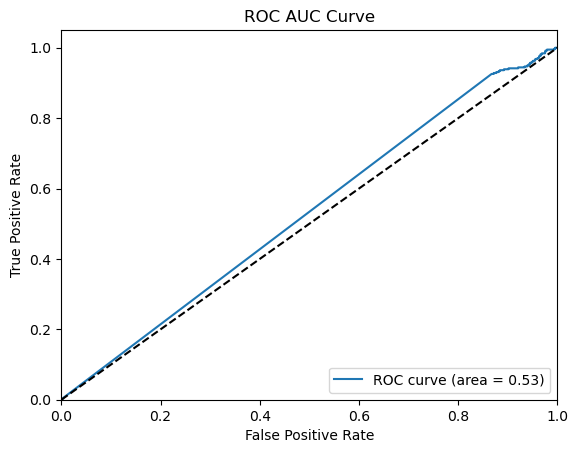

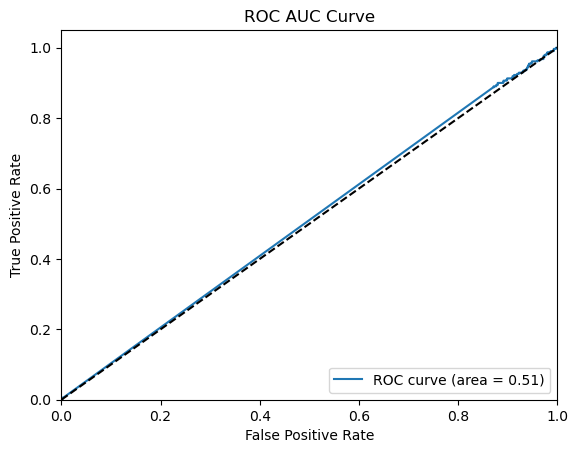

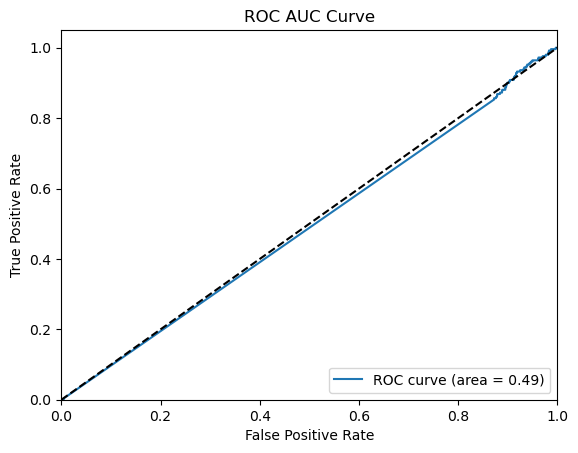

In [28]:
#training Prediction and tokenized sets
#X_train = Xdata_train
y_train = train_target_df

#testing Prediction and tokenized sets

#X_test = Xdata_test
y_test = test_target_df

y_train = label_binarize(y_train, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
n_classes = 20

y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
n_classes = 20

# classifier
clf = OneVsRestClassifier(LinearSVC(random_state=0))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [29]:
co = Xdata_train
co.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T"]

## summary of feature importance scores

C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


Feature: 0, Score: -0.05702
Feature: 1, Score: -0.06843
Feature: 2, Score: -0.06843
Feature: 3, Score: -0.06842
Feature: 4, Score: -0.06843
Feature: 5, Score: -0.06842
Feature: 6, Score: -0.06842
Feature: 7, Score: -0.06843
Feature: 8, Score: -0.05702
Feature: 9, Score: -0.05702
Feature: 10, Score: -0.05703
Feature: 11, Score: -0.05703
Feature: 12, Score: -0.05702
Feature: 13, Score: -0.05702
Feature: 14, Score: -0.05703
Feature: 15, Score: -0.05702
Feature: 16, Score: -0.05703
Feature: 17, Score: -0.05702
Feature: 18, Score: -0.05702
Feature: 19, Score: -0.05702
Feature: 20, Score: -0.05703
Feature: 21, Score: -0.05702
Feature: 22, Score: -0.05703
Feature: 23, Score: -0.05702
Feature: 24, Score: -0.05702
Feature: 25, Score: -0.05703
Feature: 26, Score: -0.05702
Feature: 27, Score: -0.05703
Feature: 28, Score: -0.05702
Feature: 29, Score: -0.05703
Feature: 30, Score: -0.05703
Feature: 31, Score: -0.05703
Feature: 32, Score: -0.05702
Feature: 33, Score: -0.05702
Feature: 34, Score: -0.0

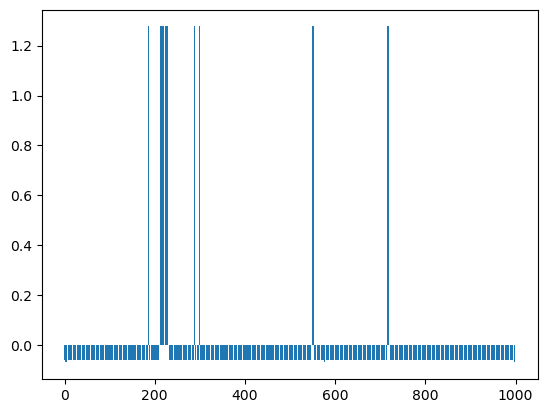

In [30]:
importance = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [31]:
w0 = clf.intercept_[0]

C:\Users\Karim\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `intercept_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


# confusion matrix for all the news groups (categories)

In [32]:
##logistic regression
X_train=vectorizer.fit_transform(train_documents)
lr_clf = LogisticRegression()
lr_clf.fit(X_train.toarray(), train_targets)

LogisticRegression()

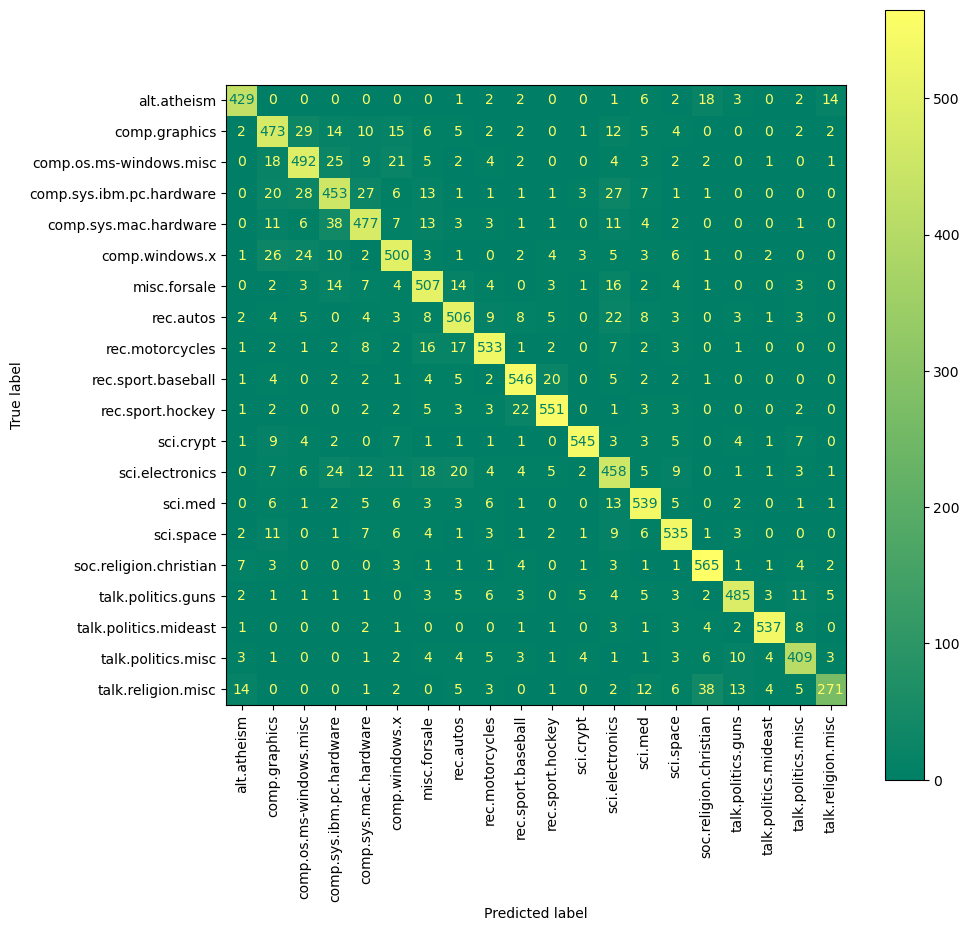

In [33]:


##tranform to TF-IDF format
#vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
#X_train = vectorizer.fit_transform(train_documents)

news_pred = lr_clf.predict(X_train.toarray())

##confusion matrix creation
# lr_pred = lr_clf.predict(X_test.toarray())
cm = confusion_matrix(train_targets, news_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=news_train.target_names)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

# correlation matrix 

In [34]:
correlation = Xdata_train.corr()
correlation

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T
A,1.000000,-0.000244,-0.000067,0.000077,-0.000193,0.000071,-0.000105,0.000053,-0.000043,-0.000283,0.000014,-0.000040,0.000062,-0.000116,-0.000173,-0.000101,-0.000083,0.000105,0.000137,-0.000051
B,-0.000244,1.000000,-0.059011,-0.127689,-0.035459,0.000098,-0.000145,0.000074,-0.000059,-0.000392,0.000019,-0.000055,0.000086,-0.000160,-0.000239,-0.000140,-0.000115,0.000145,0.000189,-0.000071
C,-0.000067,-0.059011,1.000000,-0.232302,-0.064054,0.000027,-0.000040,0.000020,-0.000016,-0.000108,0.000005,-0.000015,0.000024,-0.000044,-0.000066,-0.000038,-0.000032,0.000040,0.000052,-0.000020
D,0.000077,-0.127689,-0.232302,1.000000,-0.138692,-0.000031,0.000046,-0.000023,0.000018,0.000123,-0.000006,0.000017,-0.000027,0.000050,0.000075,0.000044,0.000036,-0.000046,-0.000059,0.000022
E,-0.000193,-0.035459,-0.064054,-0.138692,1.000000,0.000077,-0.000114,0.000058,-0.000046,-0.000309,0.000015,-0.000043,0.000068,-0.000126,-0.000189,-0.000111,-0.000091,0.000114,0.000149,-0.000056
F,0.000071,0.000098,0.000027,-0.000031,0.000077,1.000000,-0.004788,0.002092,-0.000610,-0.000535,0.001591,-0.000431,0.000103,0.006136,0.000260,-0.000311,-0.004226,-0.003647,0.001613,0.000203
G,-0.000105,-0.000145,-0.000040,0.000046,-0.000114,-0.004788,1.000000,-0.002019,0.001925,-0.001240,-0.000246,-0.000108,-0.003987,-0.003481,-0.003922,-0.002487,0.002147,0.000845,-0.002617,0.000801
H,0.000053,0.000074,0.000020,-0.000023,0.000058,0.002092,-0.002019,1.000000,-0.001427,0.001162,0.001925,0.000299,0.002198,0.000288,0.001715,-0.004004,-0.003172,-0.002693,-0.003251,0.003424
I,-0.000043,-0.000059,-0.000016,0.000018,-0.000046,-0.000610,0.001925,-0.001427,1.000000,-0.002143,-0.003131,0.000974,-0.004091,-0.002919,0.002369,-0.002532,-0.002738,-0.001706,0.001881,-0.000296
J,-0.000283,-0.000392,-0.000108,0.000123,-0.000309,-0.000535,-0.001240,0.001162,-0.002143,1.000000,0.000087,0.001678,0.003139,-0.002978,0.003453,0.000145,-0.000843,0.001915,-0.000687,-0.001000


## outlier plots

<AxesSubplot:>

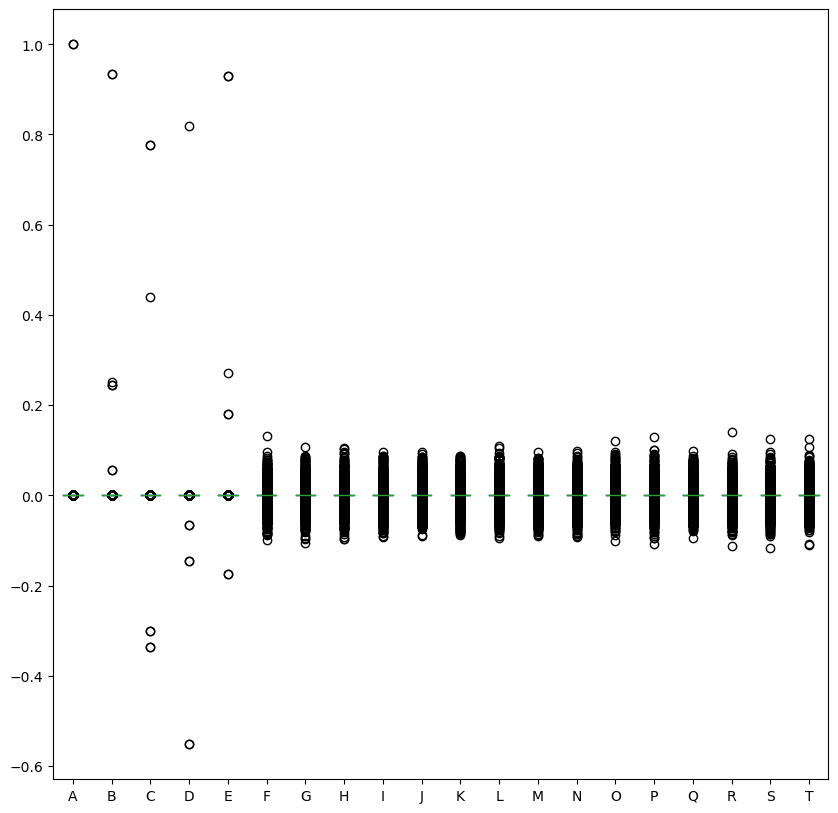

In [35]:
Xdata_train.plot(kind='box',figsize =(10,10))

# heat map

Text(0.5, 1.0, 'Heat Map')

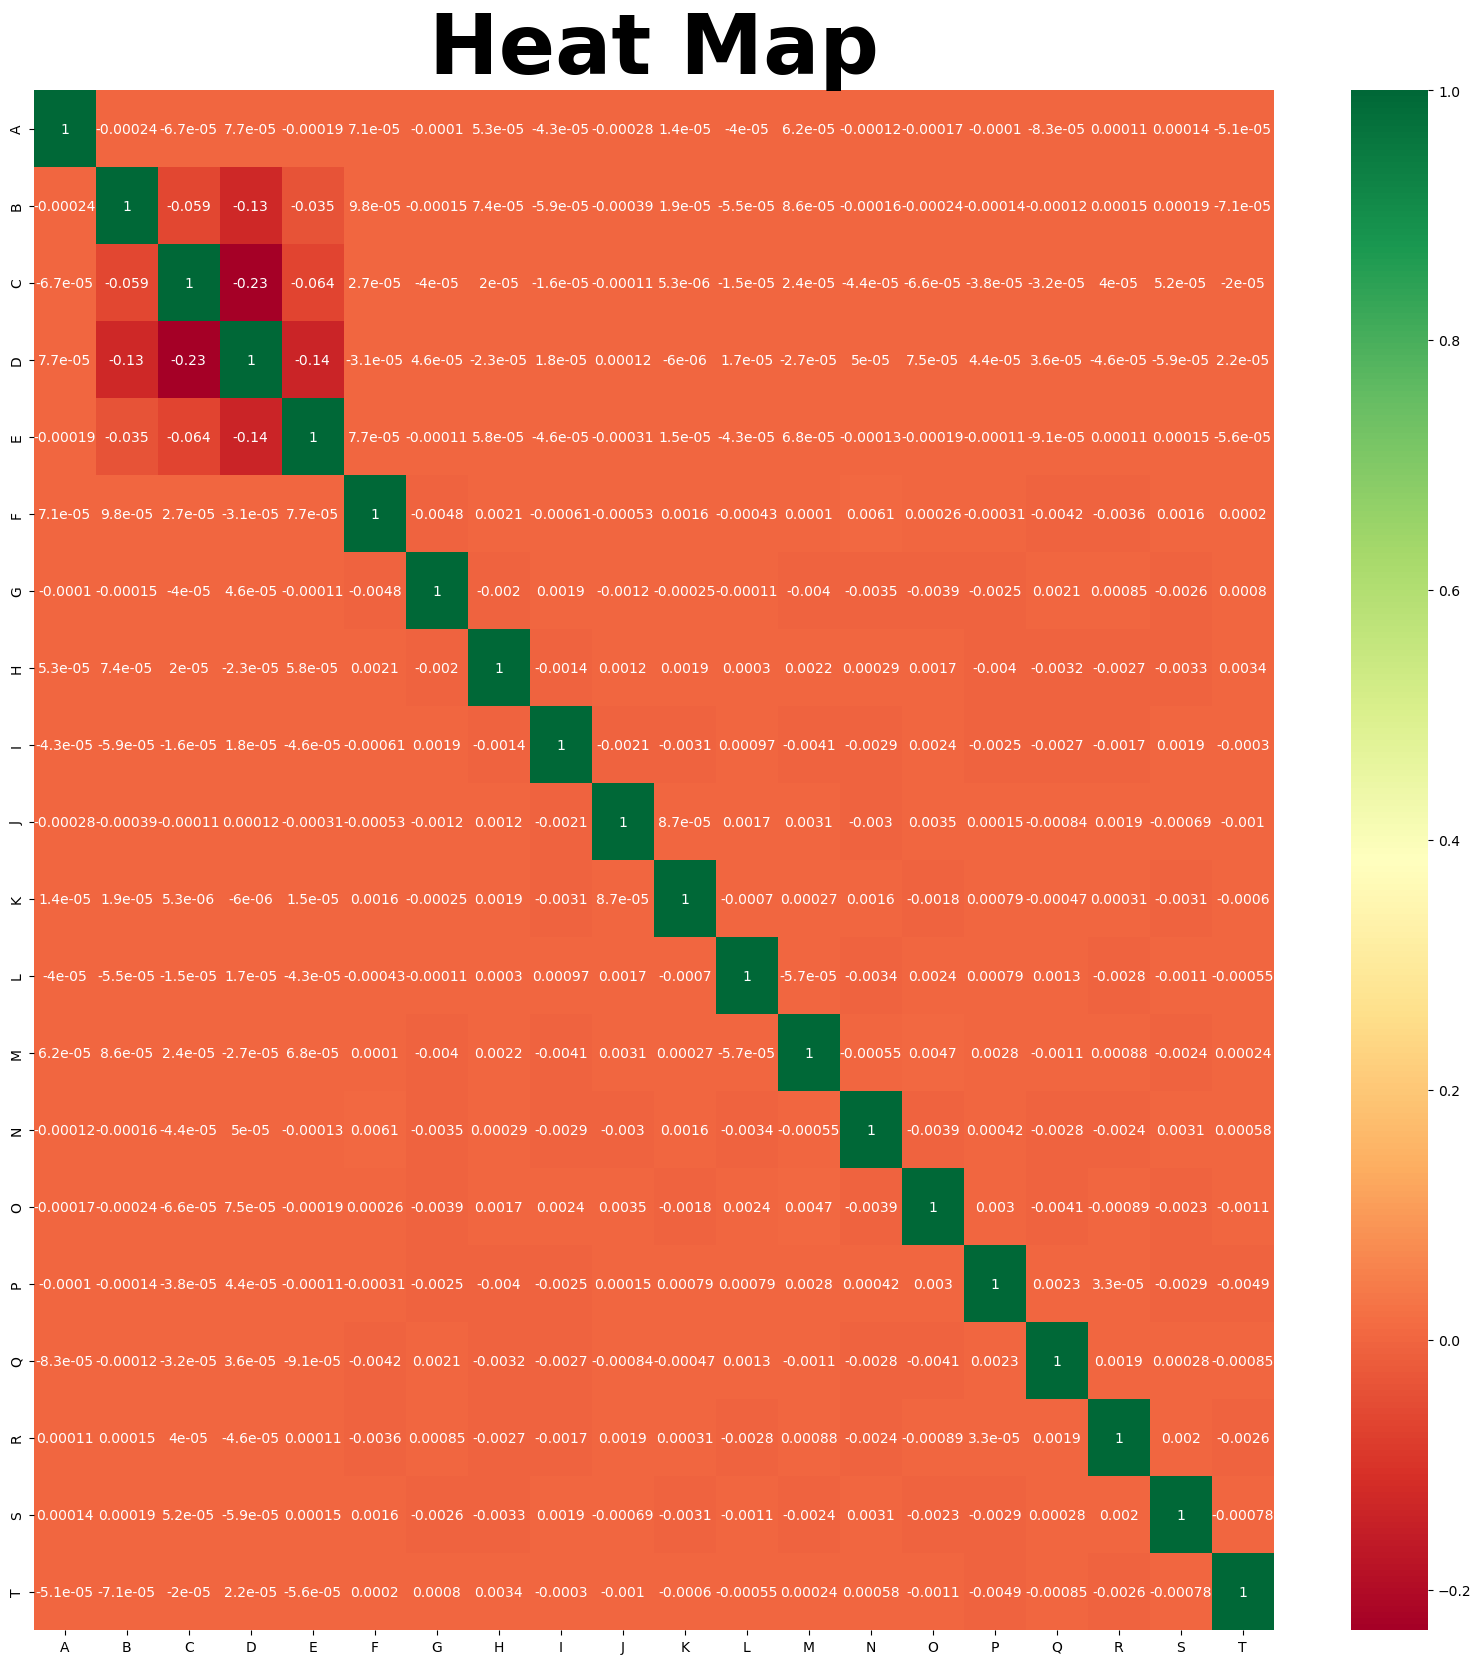

In [36]:
plt.figure(figsize=(20,20))
heatmap=sb.heatmap(correlation, annot=True,cmap='RdYlGn')
heatmap.set_title("Heat Map",fontsize=60, fontweight='bold')